In [1]:
import numpy as np
import re
import os
import random

import tensorflow as tf
import tensorflow_datasets as tfds

target_shape = (96, 96)
BATCH_SIZE = 512
images_path = os.getcwd() + "\Dataset"

In [2]:
import cv2

def preprocess_image(filename):
    """
    Load the specified file, preprocess it and
    resize it to the target shape.
    """
    img = cv2.imread(filename)
    img = cv2.resize(img, target_shape)
    return img

In [3]:
from sklearn.model_selection import train_test_split

dicImages = {}
dataset_x = []; dataset_y = []
for dirs in os.listdir(images_path):
    for f in os.listdir(images_path+'\\'+dirs):
        fClass = int(re.findall('[0-9]+', f)[0])
        dataset_x.append(images_path+'\\'+dirs+'\\'+f)
        dataset_y.append(fClass)
    
dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)
    
x_train, x_val, label_train, label_val = train_test_split(dataset_x, dataset_y, test_size=0.1)

print(dataset_x.shape, dataset_y.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

del(dataset_x)
del(dataset_y)

(55270,) (55270,)
(49743,) (49743,)
(5527,) (5527,)


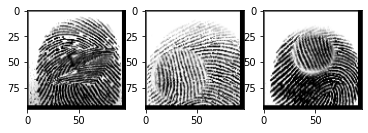

In [4]:
import matplotlib.pyplot as plt

plt.subplot(1,3,1)
plt.imshow(preprocess_image(random.choice(x_train)))

plt.subplot(1,3,2)
plt.imshow(preprocess_image(random.choice(x_train)))

plt.subplot(1,3,3)
plt.imshow(preprocess_image(random.choice(x_train)))

In [5]:
from sklearn.utils import shuffle
from imgaug import augmenters as iaa

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, label, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch_tmp = self.x[index*self.batch_size:(index+1)*self.batch_size]
        x1_batch = []
        for f in x1_batch_tmp: x1_batch.append(preprocess_image(f))
        x1_batch = np.array(x1_batch)
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        x1_batch = tf.keras.applications.vgg19.preprocess_input(x1_batch)
                
        return x1_batch, label_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [6]:
train_gen = DataGenerator(x_train, label_train, batch_size=BATCH_SIZE, shuffle=True)
val_gen = DataGenerator(x_val, label_val, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def Get_Model():
    vgg = tf.keras.applications.vgg19.VGG19(input_shape=target_shape+(3,), include_top=False, weights='imagenet')
    vgg.trainable = False

    flatten = layers.Flatten()(vgg.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.Dropout(0.2)(dense1)
    #dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.Dropout(0.2)(dense2)
    #dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)
    output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output)

    return Model(vgg.input, output, name="Embedding")
    
model = Get_Model()

In [9]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tfa.losses.TripletSemiHardLoss())

history = model.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=5)

Epoch 1/5
97/97 [==============================] - 284s 3s/step - loss: 0.8303 - val_loss: 0.6908
Epoch 2/5
97/97 [==============================] - 277s 3s/step - loss: 0.8245 - val_loss: 0.6964
Epoch 3/5
97/97 [==============================] - 291s 3s/step - loss: 0.8256 - val_loss: 0.6900
Epoch 4/5
97/97 [==============================] - 258s 3s/step - loss: 0.8243 - val_loss: 0.6962
Epoch 5/5
97/97 [==============================] - 233s 2s/step - loss: 0.8236 - val_loss: 0.6974


In [40]:
model.save_weights('tripletLoss_weight.h5')

In [8]:
model.load_weights('tripletLoss_weight.h5')

In [25]:
def Test_Image(Anchor_img, Test_img):

    anchor = preprocess_image(Anchor_img)
    test = preprocess_image(Test_img)

    anchor = tf.expand_dims(anchor, 0)
    test = tf.expand_dims(test, 0)

    anchor_embedding, test_embedding = (
        model(anchor),
        model(test),
    ) # Return (1, 256) Vector = last logits from model
    
    ap_distance = tf.reduce_sum(tf.square(anchor_embedding - test_embedding), 1)
    
    return ap_distance.numpy()
    
tab = [[], [], []]
for f in os.listdir(images_path+'/Real'):
    fClass = int(re.findall('[0-9]+', f)[0])
    if(fClass == 1 and str(f) != '1__M_Left_index_finger.BMP'):
        res = Test_Image(images_path+'/Real/1__M_Left_index_finger.BMP', images_path+'/Real/'+str(f))
        tab[0].append(res)
    elif(fClass == 2):
        res = Test_Image(images_path+'/Real/1__M_Left_index_finger.BMP', images_path+'/Real/'+str(f))
        tab[1].append(res)
    elif(fClass == 3):
        res = Test_Image(images_path+'/Real/1__M_Left_index_finger.BMP', images_path+'/Real/'+str(f))
        tab[2].append(res)
        
moy = [0, 0, 0]
for i in range(len(tab)):
    for emb in tab[i]:
        moy[i] += emb
    moy[i] = moy[i]/len(tab[i])

print('')
for i in range(len(tab)):
    print('Average from class '+str(i+1)+': '+str(moy[i]))

print('\nWe can observe that distances from positives images are lesser than negatives images !')


Average from class 1: [0.7804898]
Average from class 2: [1.6422211]
Average from class 3: [2.028646]

We can observe that distances from positives images are lesser than negatives images !
